## Wind directions from Kepert BL model

### Fit on real SAR cases

TODO

- In Kepert framework, the TC moves to the right. Put everything moving to the top of the page to be consistent. WAIT: I feel like in Theo's TCVA database TCs are also moving to the right of the image.

- In Kepert framework, we have the storm-relative wind speed. To convert it to a wind speed that would be observed by a radar, add the storm motion. In scatterometer acquisitions, the strongest surface winds appear on the right side (see Tamizi). So consistent with what I found.

- The BL has a time 1/I to set up. So near the Rmax this is roughly 2-min, very close to the 1-min wind speed of SAR data. Yet near R+ this is more like 2-hrs, so I would need to average (~40km) to get wind speed close to that of SAR. Yet, this doesn't change too much wind_speed as a function of theta, because near R+ the wind speed gradients are very small. Yet it justifies that asymmetries from lower-resolution images (such as Rad or Ascat) near R+ may be examined to do similar work.

- Make the model more user-friendly!!!!

- Try on TC Goni? (to link with Paper 3)

- Link with h+ and u_bar from Paper 3?

- The wind reduction factor is only on the total wind, not the tangential wind. So I will have to initialize using the wind reduction factor on the total wind, find the inflow angle, and then use these inflow angle values to compute the tangential wind, on which I reapply the wind reduction factor, and so on until the model converges.

- If I do a composite analysis, remove storms from the southern hemisphere

WHYs

- To compute the WN1 in Kepert at R+, I need to use the R+ of SAR. This is because sharp gradients in the vorticity profiles when I ~ V/r, which prevents from efficiently computing R+. So I will probably also have to use the Rmax of SAR to be consistent.

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
#########################
### General functions ###
#########################
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def h80(r, vm, rm, B, lat, vmin=0):
    '''Holland 1980 profile.'''
    fcor = coriolis(lat)
    V    = r * 0.
    V    = vmin + np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#########################
### KEPERT 2001 MODEL ###
#########################
# Inertial stability
def I(Rs, Vs, fcor):
    dr   = np.diff(Rs[0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(Rs, Vs, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.diff(Rs[0, :])[0] # meteRs
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi / zeta)

def eta(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * ((Vs / Rs) + I(Rs, Vs, fcor))))

def ki(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * I(Rs, Vs, fcor)))

def psi(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / abs(K * ((Vs / Rs) - I(Rs, Vs, fcor))))

# Amplitudes
def A0(Rs, Vs, K, C, fcor):
    num = -ki(Rs, Vs, K, C, fcor) * Vs * [1 + 1j * (1 + ki(Rs, Vs, K, C, fcor))]
    den = 2 * ki(Rs, Vs, K, C, fcor) ** 2 + 3 * ki(Rs, Vs, K, C, fcor) + 2
    return num / den

def A1(Rs, Vs, Ut, K, C, fcor):
    num = -eta(Rs, Vs, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 - sqrt_alpha_beta(Rs, Vs, fcor)) * psi(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [(2 + 2j) * (1 + eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)) + 3 * eta(Rs, Vs, K, C, fcor) + 3j * psi(Rs, Vs, K, C, fcor)]
    return num / den

def A_1(Rs, Vs, Ut, K, C, fcor):
    num = -psi(Rs, Vs, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(Rs, Vs, fcor)) * eta(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [(2 + 2j) * (1 + eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)) + 3 * psi(Rs, Vs, K, C, fcor) + 3j * eta(Rs, Vs, K, C, fcor)]
    return num / den

def A1_prime(Rs, Vs, Ut, K, C, fcor):
    num = -eta(Rs, Vs, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 - 1j) * (1 - sqrt_alpha_beta(Rs, Vs, fcor)) * psi(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [2 + 2j + 3 * (eta(Rs, Vs, K, C, fcor) + psi(Rs, Vs, K, C, fcor)) + (2 - 2j) * eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)]
    return num / den

def A_1_prime(Rs, Vs, Ut, K, C, fcor):
    num = -psi(Rs, Vs, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(Rs, Vs, fcor)) * eta(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [2 - 2j + 3 * (eta(Rs, Vs, K, C, fcor) + psi(Rs, Vs, K, C, fcor)) + (2 + 2j) * eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)]
    return num / den

# Radial and tangential wind components at the surface (z = 0)
def u0(Rs, Vs, K, C, fcor):
    '''At the surface (z = 0)'''
    u0 = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A0(Rs, Vs, K, C, fcor))
    return np.reshape(u0,  np.shape(u0)[1:])

def v0(Rs, Vs, K, C, fcor):
    '''At the surface (z = 0)'''
    v0 = np.imag(A0(Rs, Vs, K, C, fcor))
    return np.reshape(v0,  np.shape(v0)[1:])

def u1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1(Rs, Vs, Ut, K, C, fcor)       * np.exp(1j * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(1j * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A1(Rs, Vs, Ut, K, C, fcor)       * np.exp(1j * THs))
    otherwise = np.imag(A1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(1j * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

def u_1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1(Rs, Vs, Ut, K, C, fcor)       * np.exp(-1j * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(-1j * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v_1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A_1(Rs, Vs, Ut, K, C, fcor)       * np.exp(-1j * THs))
    otherwise = np.imag(A_1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(-1j * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

# TOTAL WIND COMPONENTS IN THE BL
def u_BL(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    return u_1(THs, Rs, Vs, Ut, K, C, fcor) + u0(Rs, Vs, K, C, fcor) + u1(THs, Rs, Vs, Ut, K, C, fcor)

def v_BL(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    return Vs + v_1(THs, Rs, Vs, Ut, K, C, fcor) + v0(Rs, Vs, K, C, fcor) + v1(THs, Rs, Vs, Ut, K, C, fcor)

# FINAL MODEL
def kepert2001(THs, Rs, Vs, Ut, K, C, fcor):
    # Returns Kepert wind speeds
    u_K01   = u_BL(THs, Rs, Vs, Ut, K, C, fcor)
    v_K01   = v_BL(THs, Rs, Vs, Ut, K, C, fcor)  

    # Adds the translation speed
    Utu     = Ut * np.cos(THs) # Radial component of Ut
    Utv     = -Ut * np.sin(THs) # Tangential component of Ut
    
    return u_K01 + Utu, v_K01 + Utv

#########################
### CREATE STRUCTURES ###
#########################
def get_xrDataset_polar(rs, ths, u_K01, v_K01):
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('theta', 'rad'), np.sqrt(v_K01 ** 2 + u_K01 ** 2)),
            'rad_wind':   (('theta', 'rad'), u_K01),
            'tan_wind':   (('theta', 'rad'), v_K01),
        },
        coords={
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    return kep_pol

def get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol):
    '''Slower than its polar counterpart, because 4 interpolations are performed.'''
    kep_car = xr.Dataset(
        data_vars={
            'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
            'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
        },
        coords={
            'x': dim_ref,
            'y': dim_ref,
        }
    )
    return kep_car

In [410]:
def wind_reduction_factor(Rs, Vs, K, C, fcor):
    '''wrf = surface azim. wind / gradient azim. wind'''
    ki_cst  = ki(Rs, Vs, K, C, fcor)
    num     = ki_cst ** 2 + 2 * ki_cst + 2
    den     = 2 * ki_cst ** 2 + 3 * ki_cst + 2
    return num / den

# def wn1(thetas, a, t, phi, c):
#     return a * np.cos(t * thetas + phi) + c

# def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
#     '''
#     initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
#     upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
#     '''
#     # Fitting process
#     popt, pcov = curve_fit(
#         f=wn1,
#         xdata=thetas,
#         ydata=wind_speed,
#         p0=[initial_condition, np.pi / 2, np.pi / 2, initial_condition],
#         bounds=([1., 0., 0., 1.], [upper_bound, np.pi, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
#     )
#     a, t, phi, c = popt[0], popt[1], popt[2], popt[3]
#     return a, t, phi, c

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([1., 0., 1.], [upper_bound, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

In [3]:
#########################
###  HYPERPARAMETERS  ###
#########################
# Reference grids
rs           = np.linspace(100, 5e5, 5000)
ths          = np.linspace(0, 2 * np.pi, 361)                         # in radians
Rs, THs      = np.meshgrid(rs, ths)                                   # shape (361, 5000)
Xs, Ys       = pol2cart(Rs, THs)                                      # to create cartesian dataset
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000 # to create cartesian dataset
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)                          # to create cartesian dataset

In [244]:
### OPEN THE SAR IMAGE
# Need to choose a TC for which speed is sufficiently high during most intense phases of the TC
# If possible >2023 to have RCM
# I would like to have a collocated Ascat on the RCM acquisition!!

dsg      = xr.open_dataset('/home/arthur/results/sar_extended/03_addIBT/dsg.nc')
vls, cts = np.unique(dsg.name, return_counts=True)
print(vls[cts >= 10])

dsg.where(dsg.name == 'DORA', drop=True).isel(time=7).file
ds   = dsg.where(dsg.name == 'DORA', drop=True).isel(time=7)
# a   = xr.open_dataset('/home/arthur/data/cyclobs/RCM/sar_files/s1a-ew-owi-ca-20230809t165107-20230809t165210-000003-05FD3D_sw_ep052023_cyclone_polar.nc').isel(time=0) # time = 8, Dora
dsp  = xr.open_dataset('/home/arthur/data/cyclobs/RCM/sar_files/rcm1--owi-ca-20230809t050027-20230809t050143-00003-______sw_ep052023_cyclone_polar.nc').isel(time=0) # time = 7, Dora

['DARIAN' 'DORA' 'DORIAN' 'FREDDY' 'LEE' 'MARGOT' 'SURIGAE']


In [245]:
# ### Extract WN1 metrics on the SAR
# as_rmx, _, _, cs_rmx = get_wn1(np.deg2rad(dsp.theta), dsp.sel(rad=ds.rmx, method='nearest').wind_speed, float(ds.vps), float(ds.vmx)) # SAR at Rmax
# as_rps, _, _, cs_rps = get_wn1(np.deg2rad(dsp.theta), dsp.sel(rad=ds.rps, method='nearest').wind_speed, float(ds.vps), float(ds.vmx)) # SAR at R+

### Extract WN1 metrics on the SAR
as_rmx, _, cs_rmx = get_wn1(np.deg2rad(dsp.theta), dsp.sel(rad=ds.rmx, method='nearest').wind_speed, float(ds.vps), float(ds.vmx)) # SAR at Rmax
as_rps, _, cs_rps = get_wn1(np.deg2rad(dsp.theta), dsp.sel(rad=ds.rps, method='nearest').wind_speed, float(ds.vps), float(ds.vmx)) # SAR at R+

In [246]:
### Initialize
# Fixed parameters
vmx = float(ds.vmx)
rmx = float(ds.rmx)
vmn = float(ds.vmn)
B   = float(ds.B_hol)
lat = float(ds.lat)
fcr = float(ds.fcor)
Ut  = float(ds.speed)

# Holland with fixed parameters
V   = h80(rs, vmx, rmx, B, lat, vmn)
Vs  = np.stack([V for i in range(np.shape(THs)[0])]) # Shape (361, 5000)

In [402]:
def get_kepert_asymmetries(THs, Rs, ths, rs, Vs, Ut, K, C, fcr):
    # Estimate the wind at the top of the BL with the wind reduction factor
    wrf    = wind_reduction_factor(Rs, Vs, K, C, fcor)
    Vs_try = Vs / wrf
    
    # Apply Kepert's model
    u_K01, v_K01 = kepert2001(THs, Rs, Vs, Ut, K, C, fcr) # Takes 3-4 seconds
    kep_pol      = get_xrDataset_polar(rs, ths, u_K01, v_K01)
    
    # Test
    ASS = []
    for rad in np.linspace(ds.rmx - 2000, 2 * ds.rps, 20):
        as_rmx, _,  _ = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=rad, method='nearest'), float(ds.vps), float(ds.vmx))
        ASS.append(as_rmx)
    plt.plot(np.linspace(ds.rmx - 2000, 2 * ds.rps, 20), ASS, label='K = {}'.format(K))
    
    # kep_pol.wind_speed.sel(rad=float(ds.rmx), method='nearest').plot(label='K = {}'.format(K))
    
    # # Plot asymmetries
    # kep_pol.wind_speed.sel(rad=float(ds.rmx), method='nearest').plot(label='K = {}'.format(K))
    # kep_pol.wind_speed.sel(rad=float(ds.rps), method='nearest').plot(label='K = {}'.format(K))
    
    # Extract WN1 metrics
    ak_rmx, phi, ck_rmx = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=float(ds.rmx), method='nearest'), float(ds.vps), 2 * float(ds.vmx)) # Kepert at Rmax
    # print(ak_rmx, phi, ck_rmx)
    # plt.plot(kep_pol.theta, wn1(np.deg2rad(kep_pol.theta), ak_rmx, phi, ck_rmx))
    ak_rps, _, ck_rps = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=float(ds.rps), method='nearest'), float(ds.vps), float(ds.vmx)) # Kepert at R+
    
    return ak_rmx, ck_rmx, ak_rps, ck_rps

  0%|          | 0/8 [00:00<?, ?it/s]

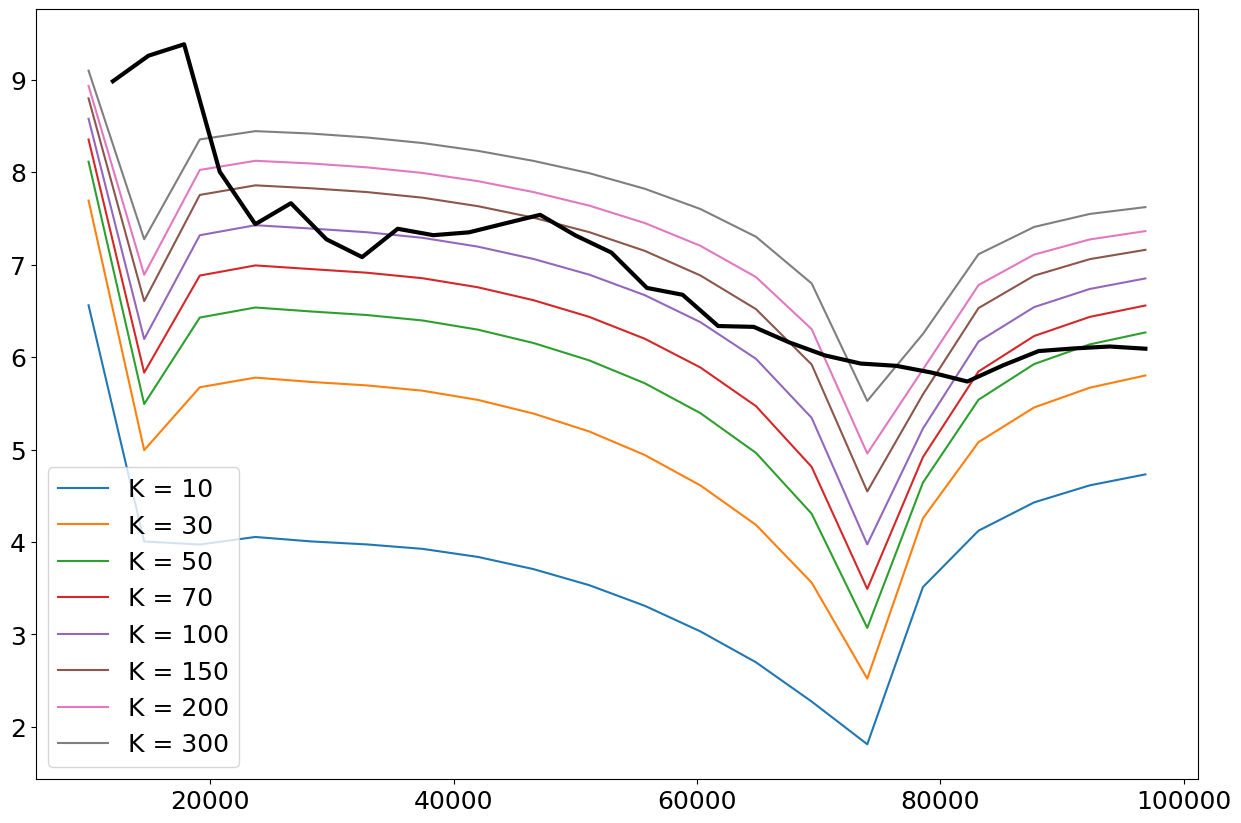

In [418]:
# Trial parameters
C   = 1.5e-3 
Ks  = [10, 30, 50, 70, 100, 150, 200, 300]
# Ks  = [150]

# Intialize
lak_rmx = []
lck_rmx = []
lak_rps = []
lck_rps = []

# Iterate
for K in tqdm(Ks):
    # Get asymmetries
    ak_rmx, ck_rmx, ak_rps, ck_rps = get_kepert_asymmetries(THs, Rs, ths, rs, Vs, Ut, K, C, fcr)
    
    # Append
    lak_rmx.append(ak_rmx)
    lck_rmx.append(ck_rmx)
    lak_rps.append(ak_rps)
    lck_rps.append(ck_rps)
    
# Test
ASS = []
for rad in np.linspace(ds.rmx, 2 * ds.rps, 30):
    as_rmx, _, _ = get_wn1(np.deg2rad(dsp.theta), dsp.sel(rad=rad, method='nearest').wind_speed.fillna(dsp.sel(rad=rad, method='nearest').wind_speed.mean(skipna=True)), float(ds.vps), float(ds.vmx)) # SAR at Rmax
    ASS.append(as_rmx)
plt.plot(np.linspace(ds.rmx, 2 * ds.rps, 30), ASS, c='k', linewidth=3)

### Extract WN1 metrics on the SAR
as_rmx, _, cs_rmx = get_wn1(np.deg2rad(dsp.theta), dsp.sel(rad=ds.rmx, method='nearest').wind_speed, float(ds.vps), float(ds.vmx)) # SAR at Rmax
as_rps, _, cs_rps = get_wn1(np.deg2rad(dsp.theta), dsp.sel(rad=ds.rps, method='nearest').wind_speed, float(ds.vps), float(ds.vmx)) # SAR at R+

# # Plot
# dsp.sel(rad=ds.rmx, method='nearest').wind_speed.plot(c='k', linewidth=3, label='SAR')
# dsp.sel(rad=ds.rps, method='nearest').wind_speed.plot(c='k', linewidth=3)
plt.legend()

In [419]:
a_diff_rmx = np.array(lak_rmx) - as_rmx
a_diff_rps = np.array(lak_rps) - as_rps
c_diff_rmx = np.array(lck_rmx) - cs_rmx
c_diff_rps = np.array(lck_rps) - cs_rps

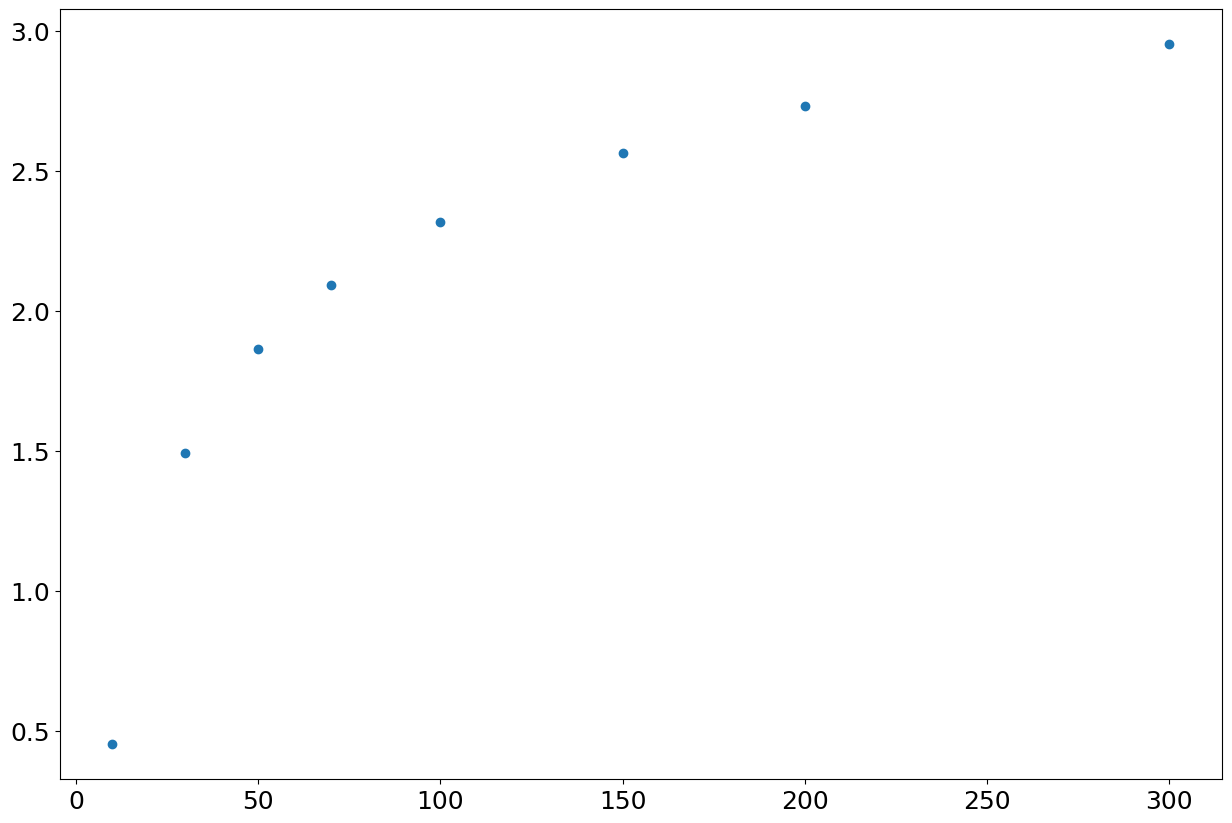

In [420]:
plt.scatter(Ks, c_diff_rps)

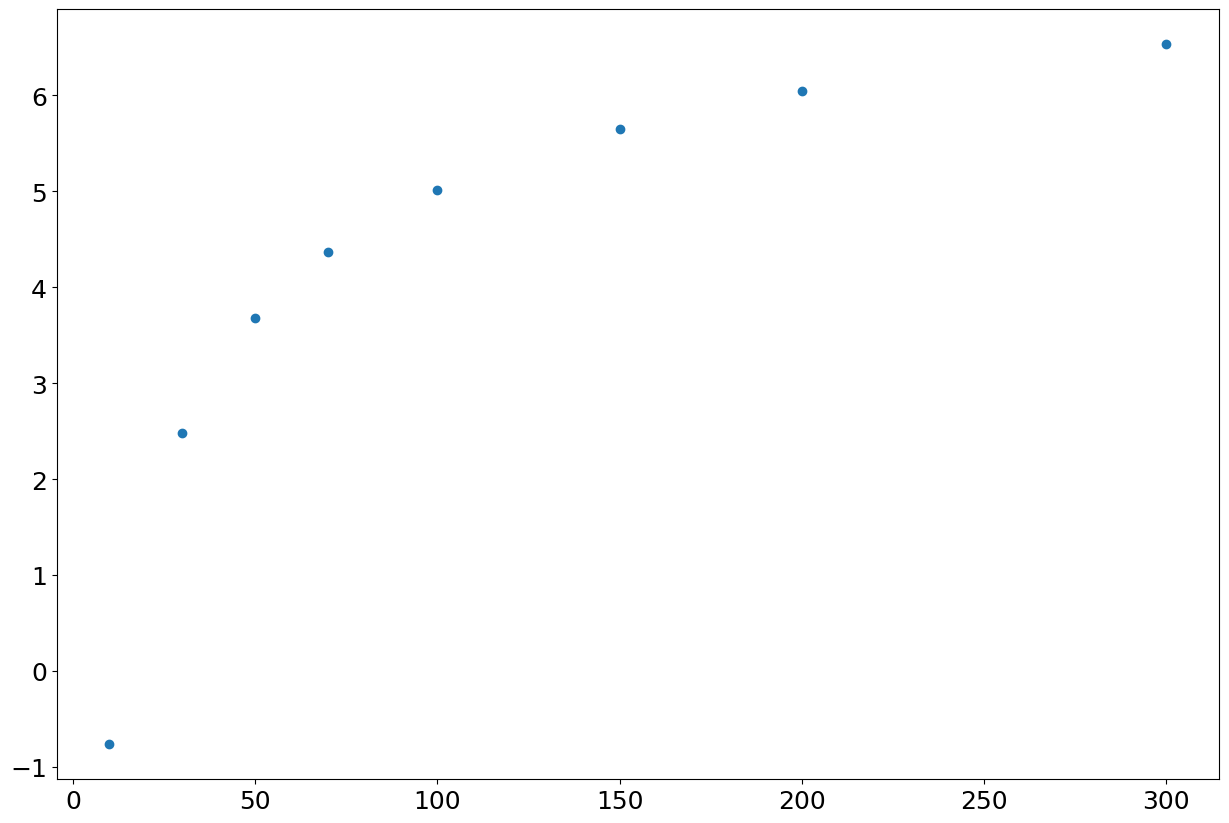

In [421]:
plt.scatter(Ks, c_diff_rmx)

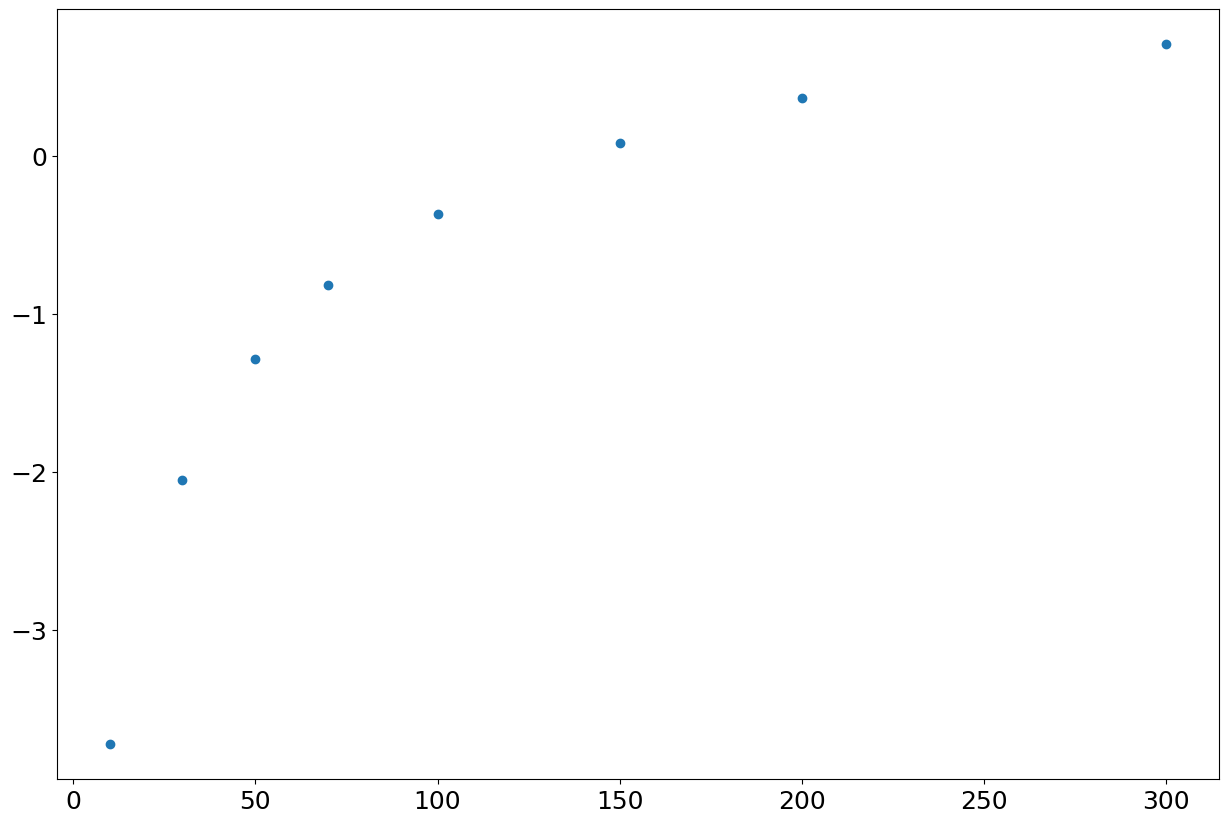

In [422]:
plt.scatter(Ks, a_diff_rps)

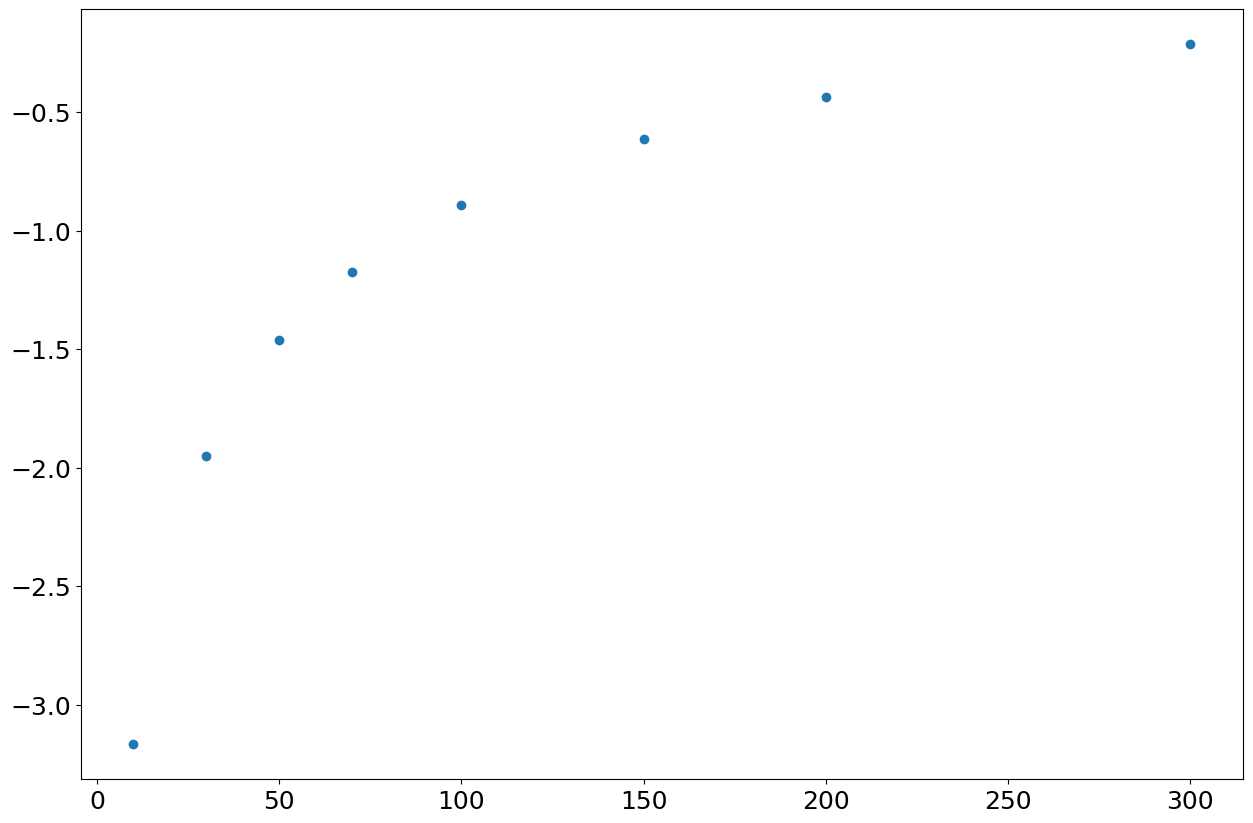

In [423]:
plt.scatter(Ks, a_diff_rmx)

In [258]:
# Trial parameters
K   = 50 # m2/s
C   = 2.5e-3 

# Get asymmetries
ak_rmx, ck_rmx, ak_rps, ck_rps = get_kepert_asymmetries(THs, Rs, ths, rs, Vs, Ut, K, C, fcr)

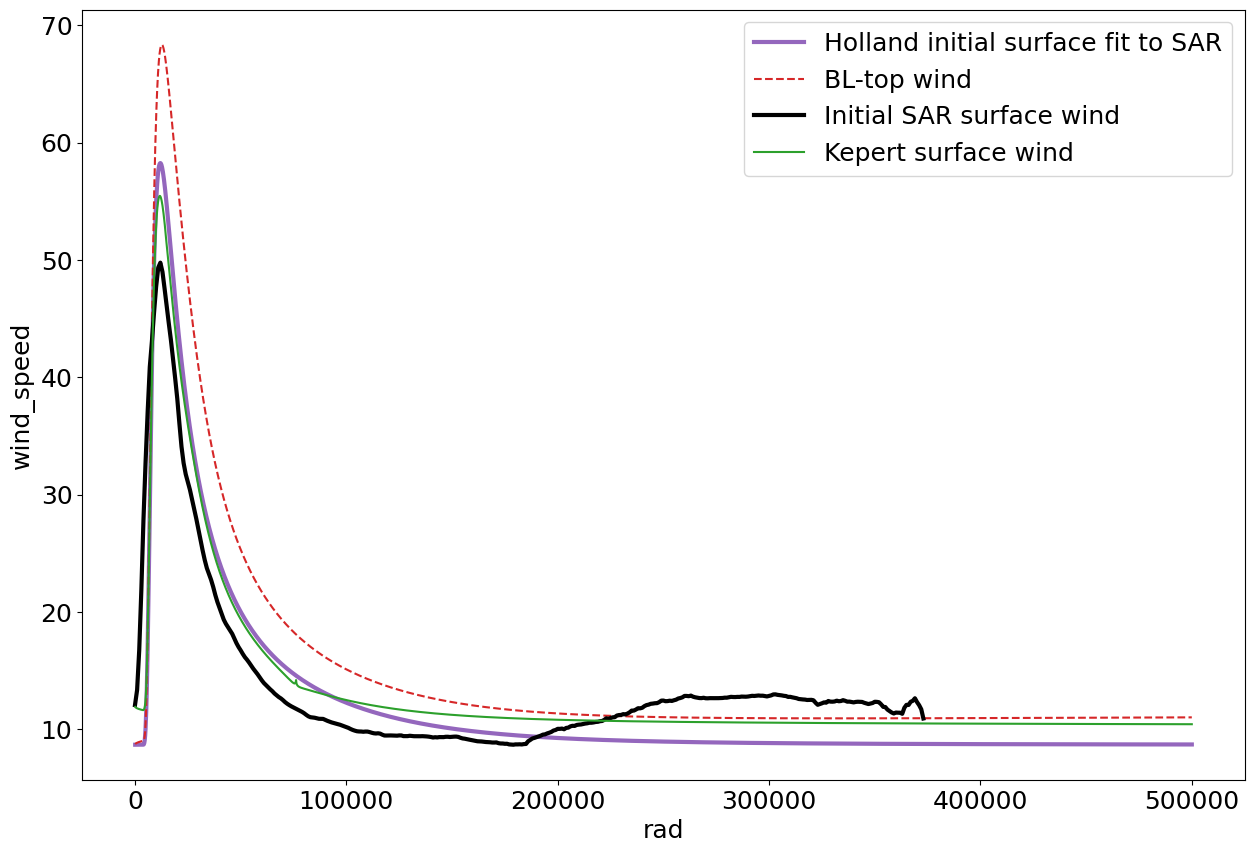

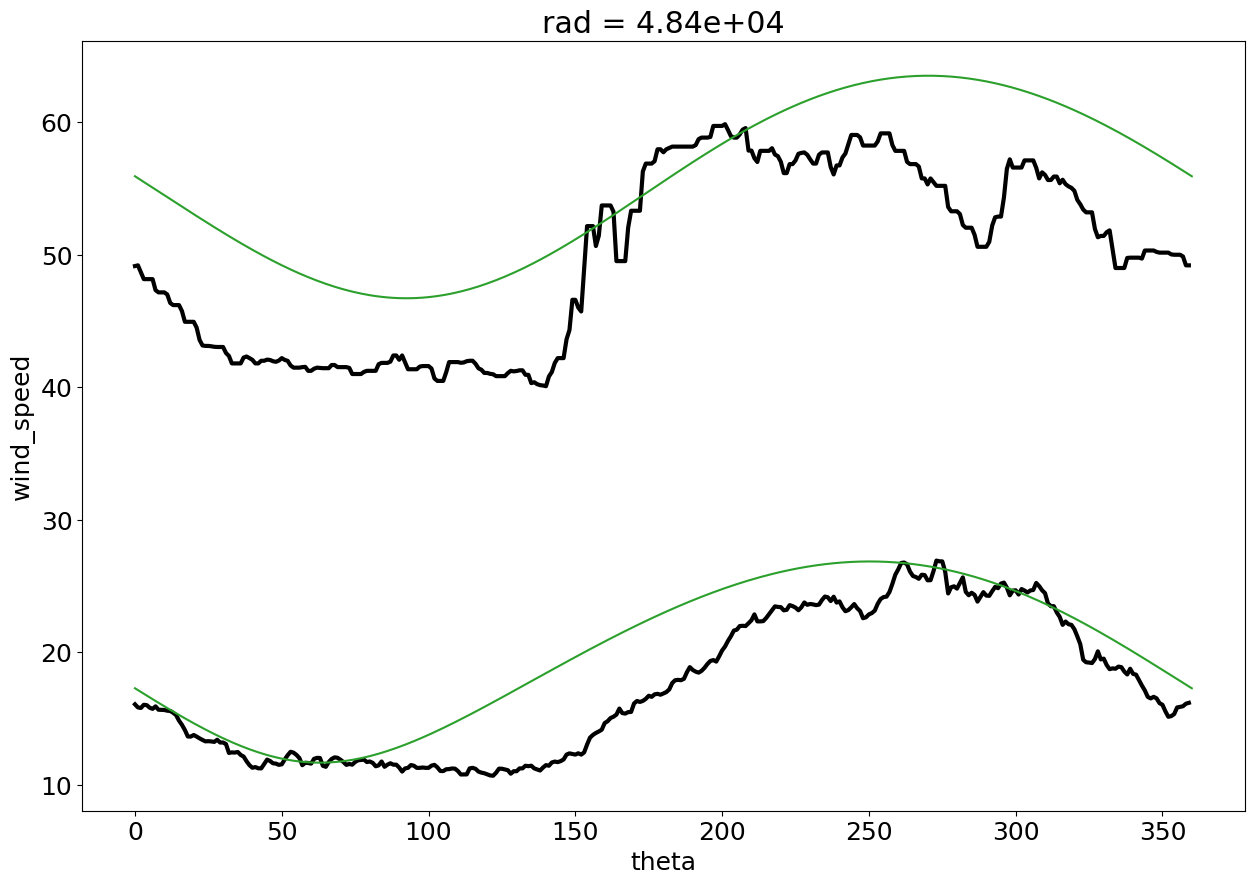

In [368]:
# Apply Kepert's model
u_K01, v_K01 = kepert2001(THs, Rs, Vs, Ut, 150, C, fcr) # Takes 3-4 seconds
kep_pol      = get_xrDataset_polar(rs, ths, u_K01, v_K01)
# kep_car      = get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol) # Takes 5-6 seconds

# Plot base profiles
plt.plot(rs, V, c='tab:purple', linewidth=3, label='Holland initial surface fit to SAR')
plt.plot(rs, Vs_try[0, :], c='tab:red', linestyle='dashed', label='BL-top wind')
dsp.wind_speed.mean(dim='theta').plot(c='k', linewidth=3, label='Initial SAR surface wind')
# Plot Kepert profiles
kep_ws  = kep_pol.wind_speed.mean(dim='theta')
kep_vmx = float(kep_ws.max())
kep_rmx = float(kep_ws.rad[kep_ws.argmax()])
kep_ws.plot(c='tab:green', label='Kepert surface wind')
plt.legend()
plt.show()

# Plot asymmetries
dsp.sel(rad=ds.rmx, method='nearest').wind_speed.plot(c='k', linewidth=3)
kep_pol.wind_speed.sel(rad=float(ds.rmx), method='nearest').plot(c='tab:green')
dsp.sel(rad=ds.rps, method='nearest').wind_speed.plot(c='k', linewidth=3)
kep_pol.wind_speed.sel(rad=float(ds.rps), method='nearest').plot(c='tab:green')

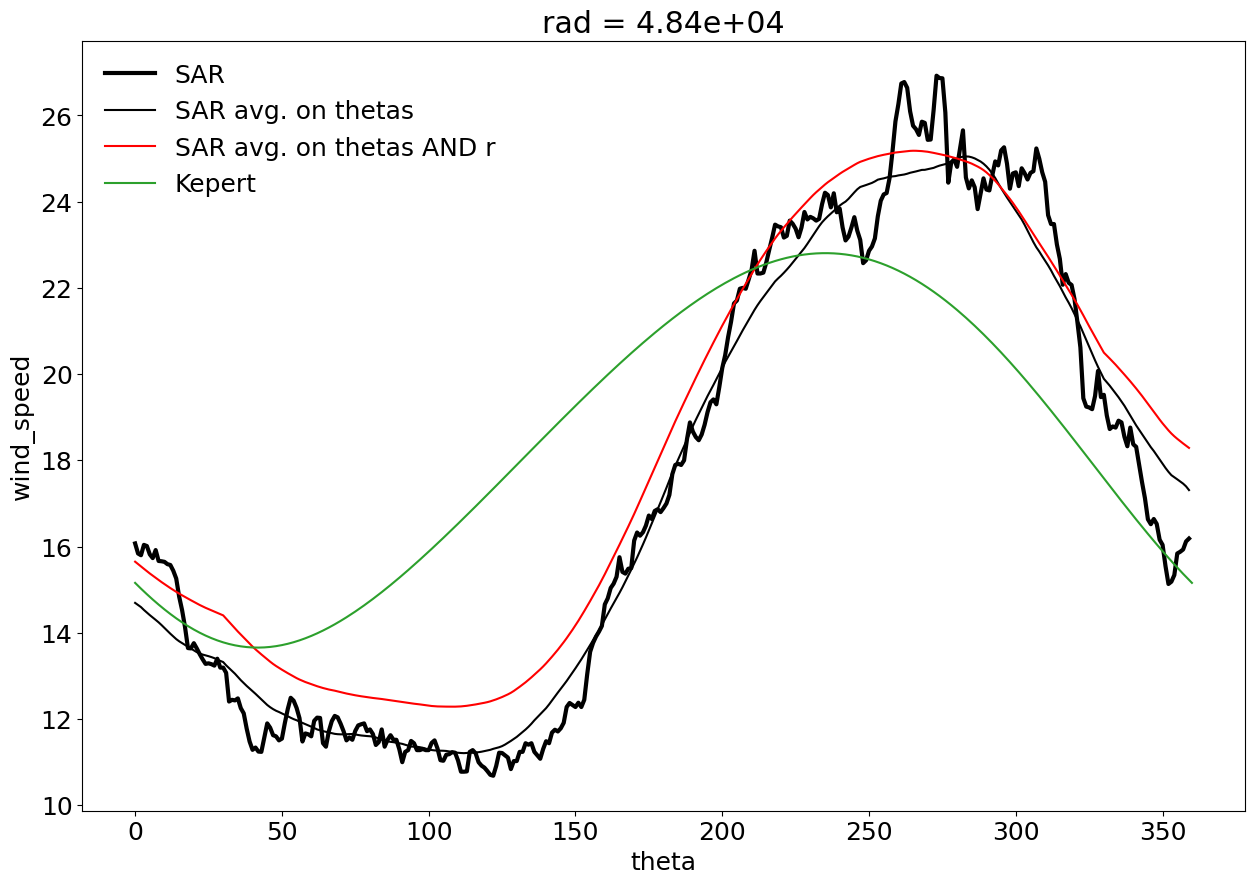

In [297]:
dsp.sel(rad=ds.rps, method='nearest').wind_speed.plot(c='k', linewidth=3, label='SAR')
dsp.sel(rad=ds.rps, method='nearest').rolling(theta=60, center=True, min_periods=2).mean().wind_speed.plot(c='k', label='SAR avg. on thetas')
dsp.sel(rad=slice(ds.rps - 20000, ds.rps + 20000)).wind_speed.mean(dim='rad', skipna=True).rolling(theta=60, center=True, min_periods=2).mean().plot(c='r', label='SAR avg. on thetas AND r')
kep_pol.wind_speed.sel(rad=float(ds.rps), method='nearest').plot(c='tab:green', label='Kepert')
plt.legend(frameon=False)

In [255]:
### Extract WN1 metrics
# At Rmax
ak_rmx, _, _, ck_rmx = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=float(ds.rmx), method='nearest'), float(ds.vps), float(ds.vmx)) # Kepert at Rmax
as_rmx, _, _, cs_rmx = get_wn1(np.deg2rad(dsp.theta),     dsp.sel(rad=ds.rmx, method='nearest').wind_speed,            float(ds.vps), float(ds.vmx)) # SAR at Rmax
# At R+
ak_rps, _, _, ck_rps = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=float(ds.rps), method='nearest'), float(ds.vps), float(ds.vmx)) # Kepert at R+
as_rps, _, _, cs_rps = get_wn1(np.deg2rad(dsp.theta),     dsp.sel(rad=ds.rps, method='nearest').wind_speed,            float(ds.vps), float(ds.vmx)) # SAR at R+

In [256]:
print(ak_rmx, ck_rmx, ak_rps, ck_rps)

1.0000000000000127 49.77151851851852 4.521793012118178 18.28992829631208


a = 6.05, t = 0.96, phi = 2.28, c = 19.07


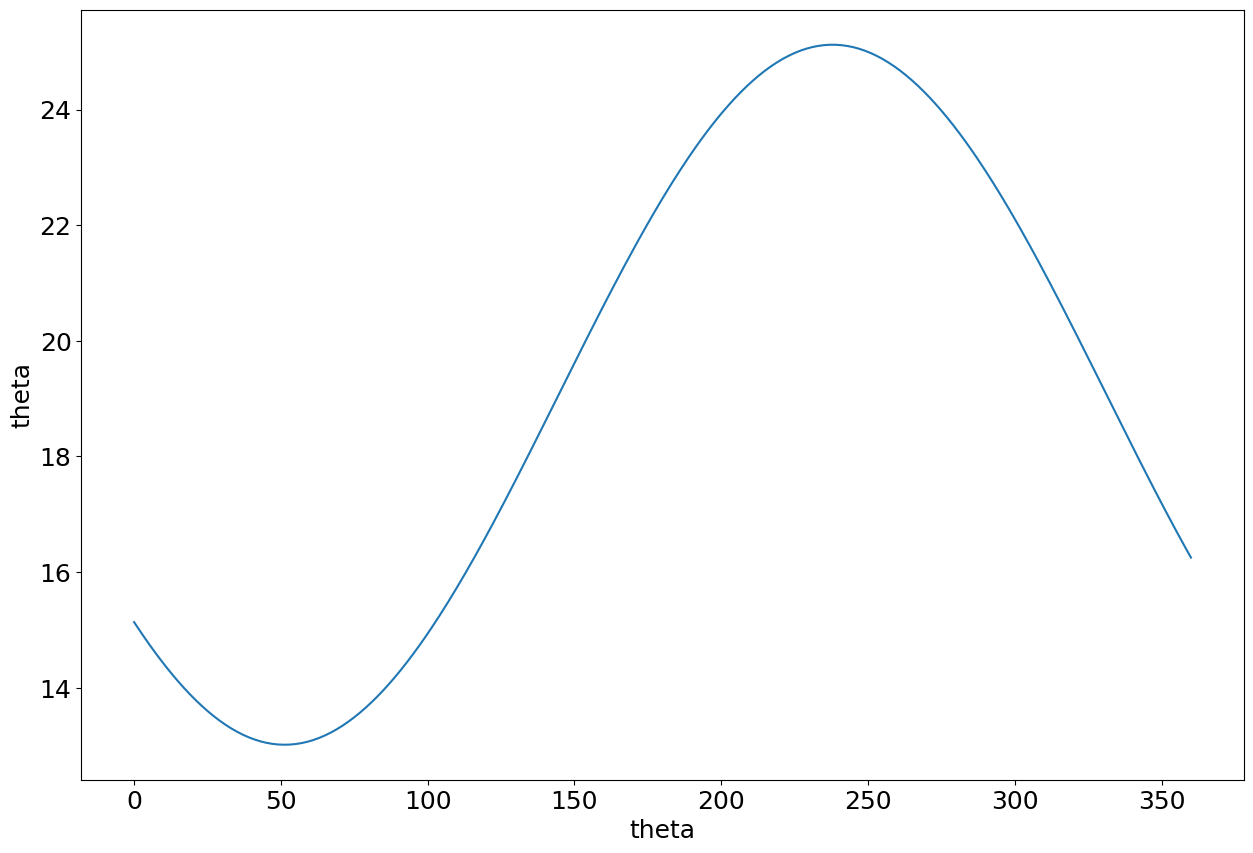

In [223]:
# Fit Kepert WN1
popt, pcov = curve_fit(
    f=wn1,
    xdata=np.deg2rad(kep_pol.theta),
    ydata=kep_pol.wind_speed.sel(rad=float(ds.rps), method='nearest'), # Use R+ from the SAR
    p0=[float(ds.vps), np.pi / 2, np.pi / 2, float(ds.vps)],
    bounds=([1., 0., 0., 1.], [float(ds.vmx), np.pi, np.pi, float(ds.vmx)]) # ([lower bounds], [upper bounds])
)
print('a = {:.2f}, t = {:.2f}, phi = {:.2f}, c = {:.2f}'.format(*popt))
wn1(np.deg2rad(kep_pol.theta), *popt).plot()

a = 7.47, t = 1.03, phi = 1.55, c = 17.34


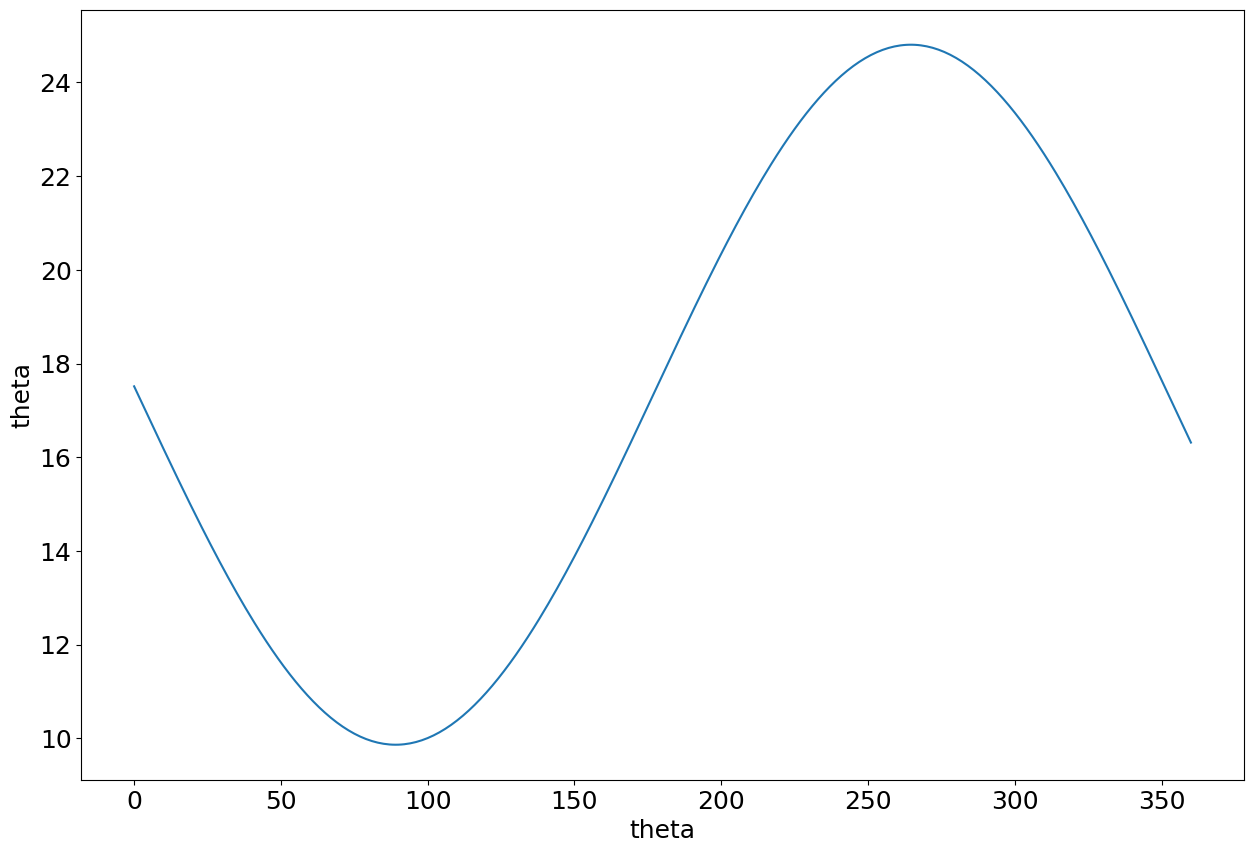

In [224]:
# Fit SAR WN1
popt, pcov = curve_fit(
    f=wn1,
    xdata=np.deg2rad(dsp.theta),
    ydata=dsp.sel(rad=ds.rps, method='nearest').wind_speed,
    p0=[float(ds.vps), np.pi / 2, np.pi / 2, float(ds.vps)],
    bounds=([1., 0., 0., 1.], [float(ds.vmx), np.pi, np.pi, float(ds.vmx)]) # ([lower bounds], [upper bounds])
)
print('a = {:.2f}, t = {:.2f}, phi = {:.2f}, c = {:.2f}'.format(*popt))
wn1(np.deg2rad(kep_pol.theta), *popt).plot()

In [204]:
kep_car      = get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol) # Takes 5-6 seconds

(-100000.0, 100000.0)

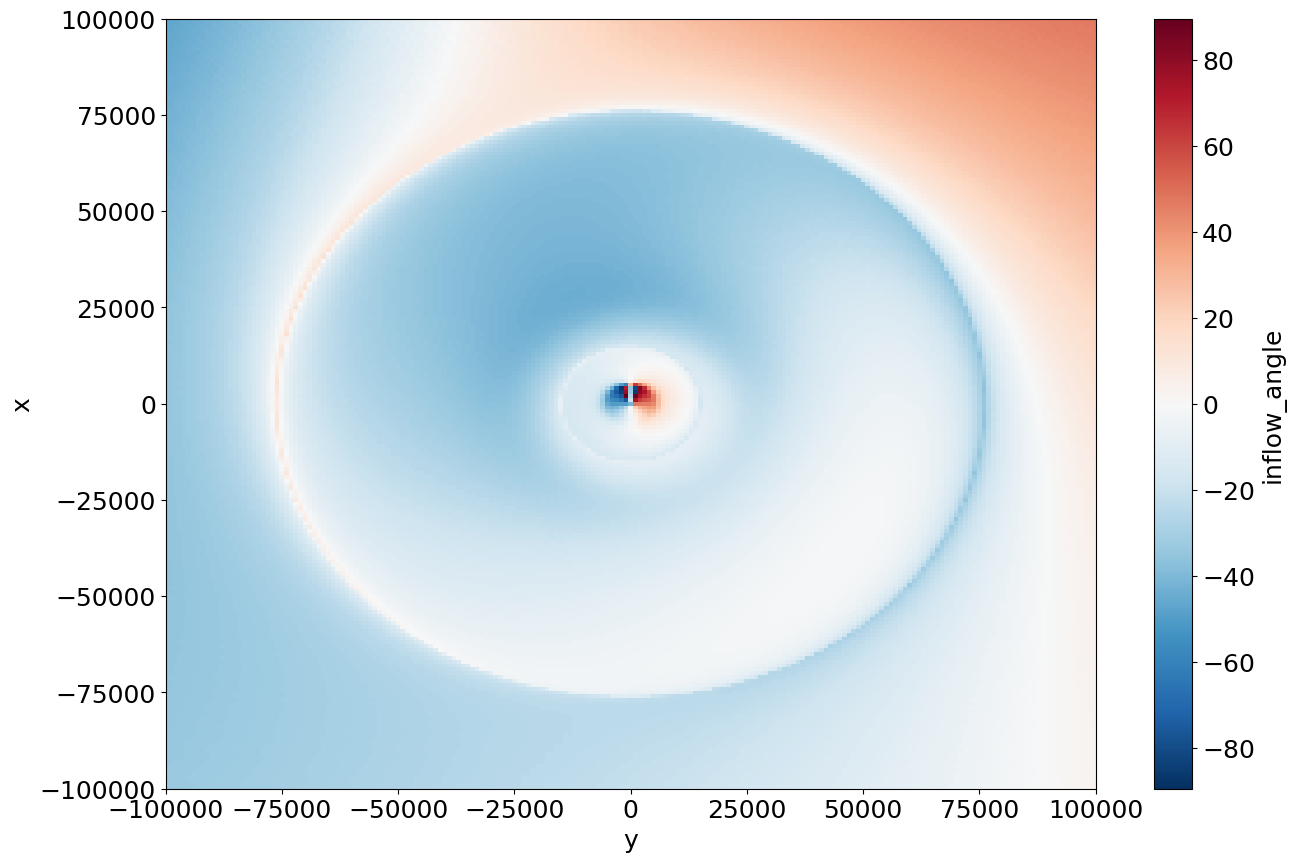

In [211]:
kep_car.inflow_angle.plot()
plt.xlim(-100000, 100000)
plt.ylim(-100000, 100000)

(-100000.0, 100000.0)

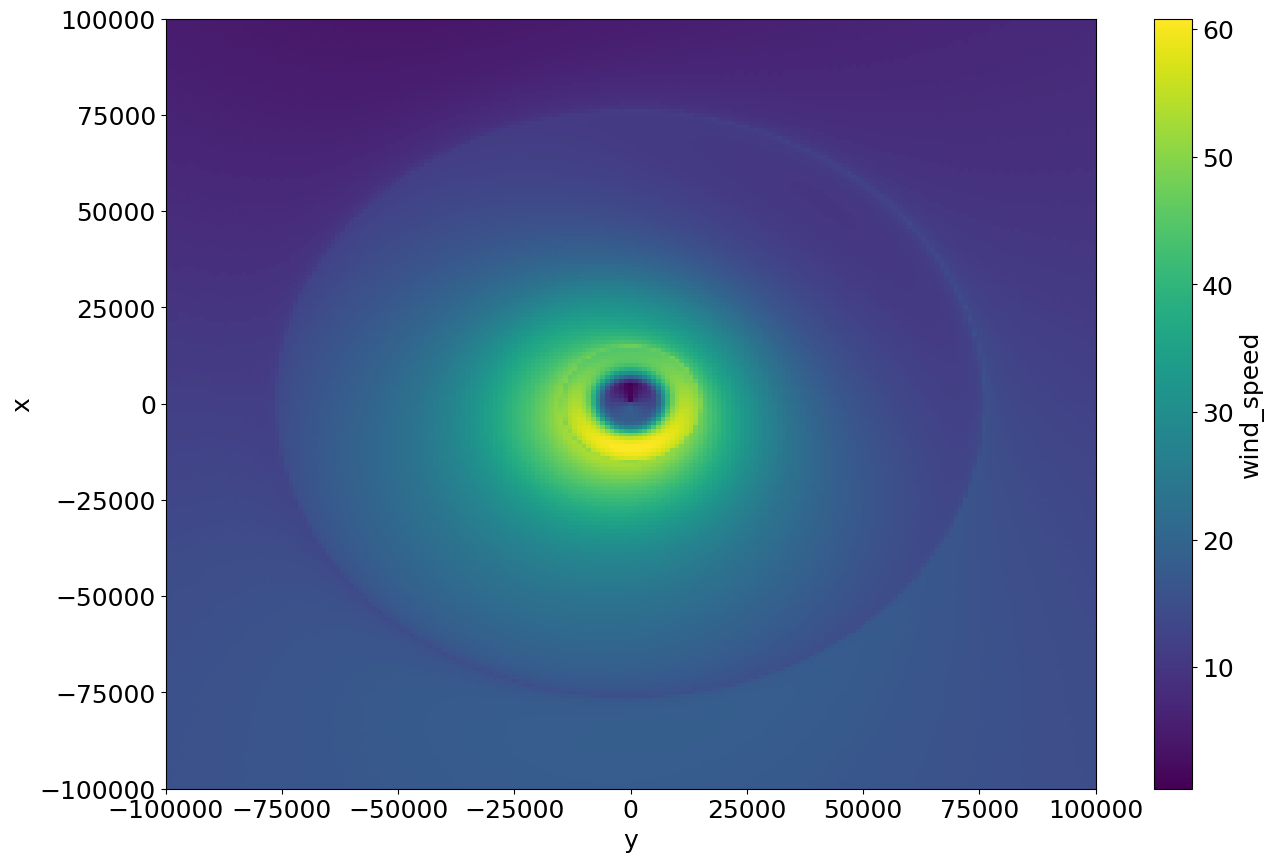

In [332]:
kep_car.wind_speed.plot()
plt.xlim(-100000, 100000)
plt.ylim(-100000, 100000)

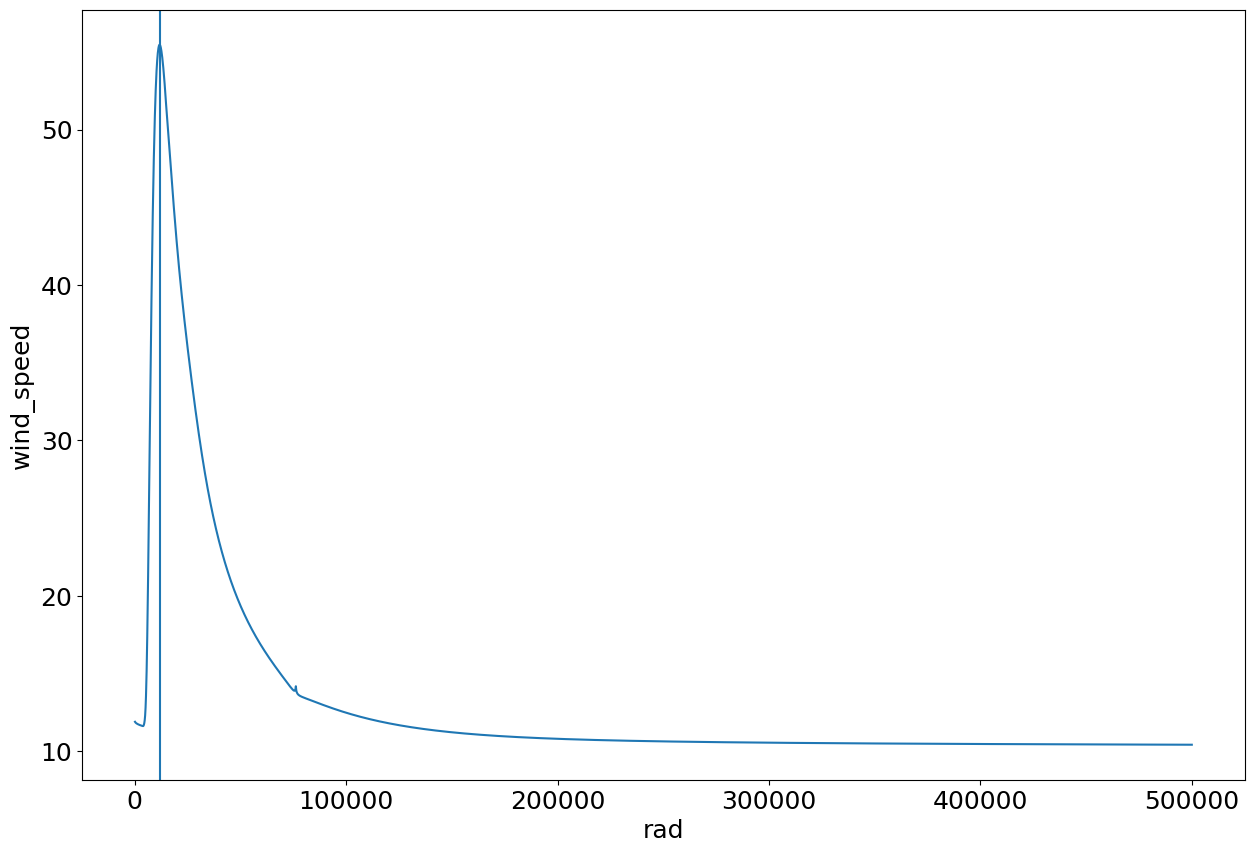

In [345]:
.plot()
plt.axvline(ds.rmx)

In [369]:
wsm = kep_pol.wind_speed.mean(dim='theta')
wss = kep_pol.wind_speed.std(dim='theta')

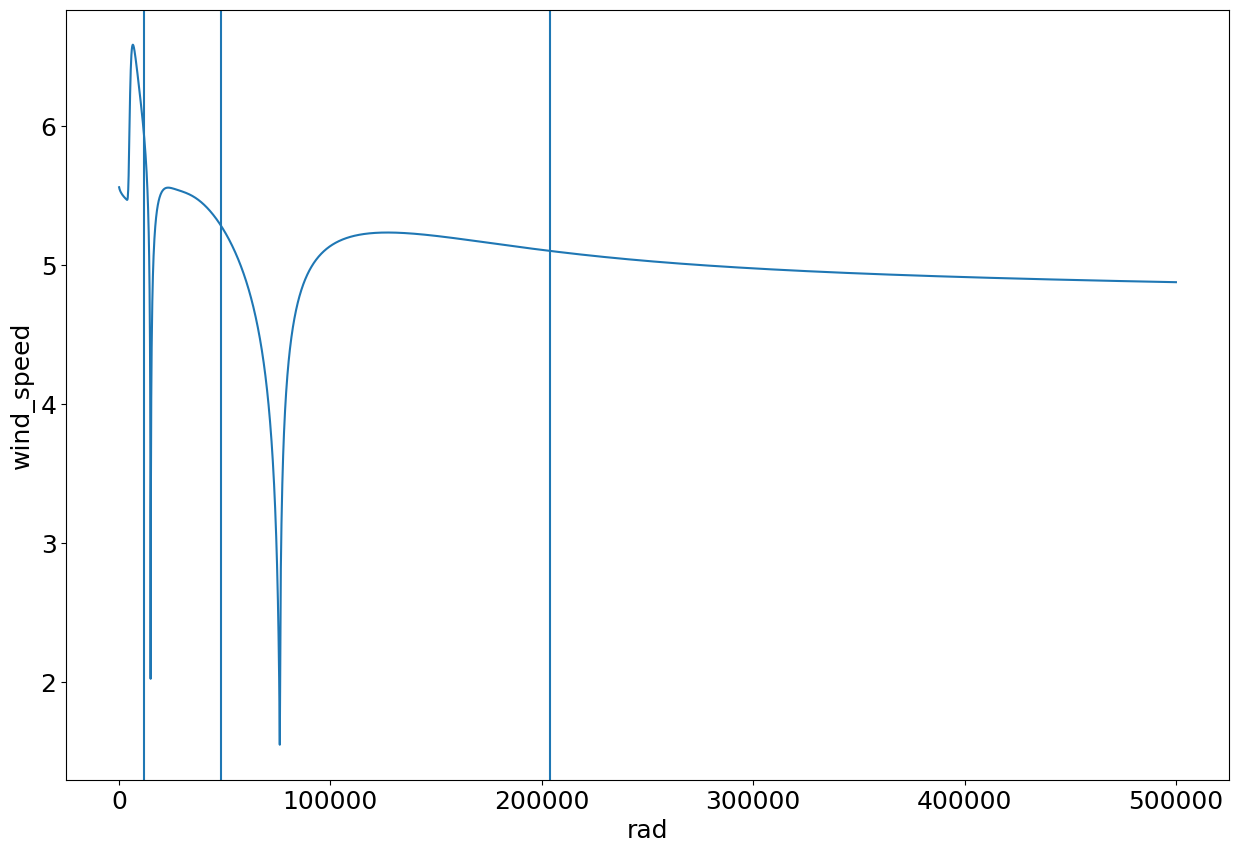

In [370]:
wss.plot()
plt.axvline(ds.rmx)
plt.axvline(ds.rps)
plt.axvline(ds.r0)